In [1]:
!git clone https://github.com/pjreddie/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 5955, done.
remote: Total 5955 (delta 0), reused 0 (delta 0), pack-reused 5955
Receiving objects: 100% (5955/5955), 6.37 MiB | 6.11 MiB/s, done.
Resolving deltas: 100% (3932/3932), done.


In [2]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2024-07-14 18:44:10--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  10.0MB/s    in 22s     

2024-07-14 18:44:33 (10.8 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [2]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from IPython.display import clear_output

In [3]:
# load YOLOv3 network
net = cv2.dnn.readNet("/content/yolov3.weights",
                      "/content/darknet/cfg/yolov3.cfg")

In [4]:
# list of classes
with open("/content/darknet/data/coco.names", "r") as f:
  classes = [line.strip() for line in f.readlines()]
print(len(classes))
print(classes)


80
['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [6]:
# overview on the layer names
layer_names = net.getLayerNames()
print(layer_names)
len(layer_names)

# access to output layers
outputlayers =net.getUnconnectedOutLayersNames()

('conv_0', 'bn_0', 'leaky_1', 'conv_1', 'bn_1', 'leaky_2', 'conv_2', 'bn_2', 'leaky_3', 'conv_3', 'bn_3', 'leaky_4', 'shortcut_4', 'conv_5', 'bn_5', 'leaky_6', 'conv_6', 'bn_6', 'leaky_7', 'conv_7', 'bn_7', 'leaky_8', 'shortcut_8', 'conv_9', 'bn_9', 'leaky_10', 'conv_10', 'bn_10', 'leaky_11', 'shortcut_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'conv_14', 'bn_14', 'leaky_15', 'shortcut_15', 'conv_16', 'bn_16', 'leaky_17', 'conv_17', 'bn_17', 'leaky_18', 'shortcut_18', 'conv_19', 'bn_19', 'leaky_20', 'conv_20', 'bn_20', 'leaky_21', 'shortcut_21', 'conv_22', 'bn_22', 'leaky_23', 'conv_23', 'bn_23', 'leaky_24', 'shortcut_24', 'conv_25', 'bn_25', 'leaky_26', 'conv_26', 'bn_26', 'leaky_27', 'shortcut_27', 'conv_28', 'bn_28', 'leaky_29', 'conv_29', 'bn_29', 'leaky_30', 'shortcut_30', 'conv_31', 'bn_31', 'leaky_32', 'conv_32', 'bn_32', 'leaky_33', 'shortcut_33', 'conv_34', 'bn_34', 'leaky_35', 'conv_35', 'bn_35', 'leaky_36', 'shortcut_36', 'conv_37', 'bn_37', 'leaky_

In [5]:
# load an image
img = cv2.imread("/content/pic.webp")
img = cv2.resize(img, None, fx=0.4, fy=0.4, )
height, width, channels = img.shape

In [7]:
# Detect objects in the image
blob = cv2.dnn.blobFromImage(img, 0.00392, (442, 442), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(outputlayers)
outs[0].shape # [number_of_detections, 4 + 1 + number_of_classes]

(588, 85)

In [8]:
# Show the detections
class_ids, confidences, boxes = [], [], []
for out in outs:
  for detection in out:
    scores = detection[5:]
    class_id = np.argmax(scores)
    confidence = scores[class_id]
    if confidence > 0.5:
      # Object detected
      center_x, center_y, w, h = (detection[0:4] * np.array([width, height, width, height])).astype('int')
      x = int(center_x - w / 2)
      y = int(center_y - h / 2)
      boxes.append([x, y, int(w), int(h)])
      confidences.append(float(confidence))
      class_ids.append(class_id)

In [9]:
# Perform non-maximum suppression to eliminate redundant overlapping boxes with lower confidences
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

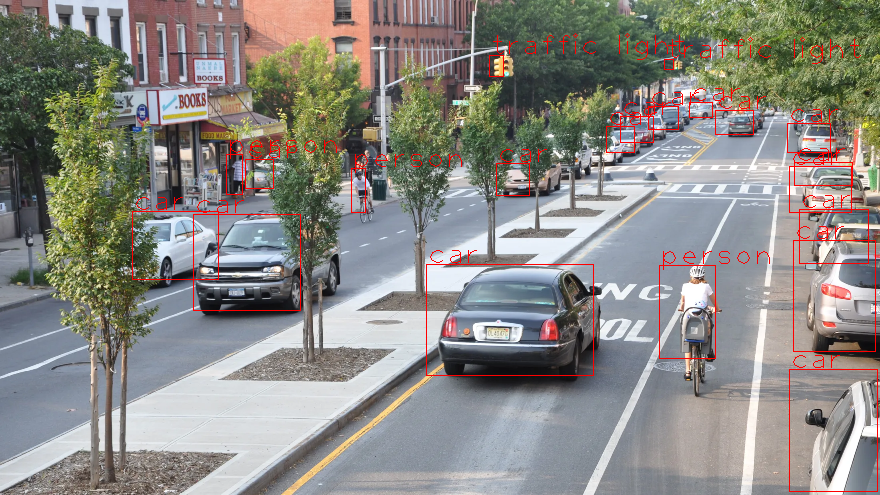

In [10]:
# Draw the bounding boxes
for i in range(len(boxes)):
  if i in indexes:
    x, y, w, h = boxes[i]
    label = str(classes[class_ids[i]])
    color = (0, 0, 255)
    cv2.rectangle(img, (x, y), (x + w, y + h), color, 1)
    cv2.putText(img, label, (x, y), 1, 2, color, 1)


cv2_imshow(img)

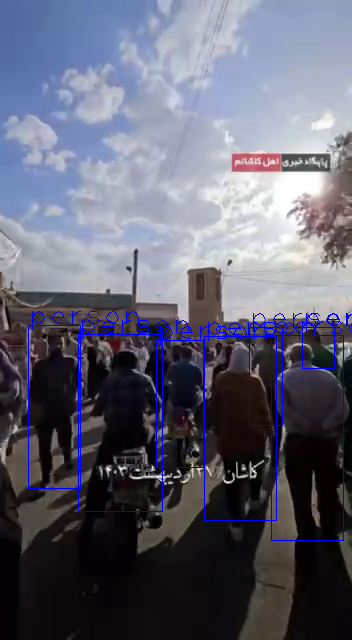

KeyboardInterrupt: 

In [8]:
cap = cv2.VideoCapture("/content/rosewatr.mov")

while True:
  # Read a frame from the video
  ret, frame = cap.read() # ret is a flag variable (True, False)

  if not ret:
      # End of video
      break

  height, width, channels = frame.shape
  blob = cv2.dnn.blobFromImage(frame, 0.00392, (442, 442), (0, 0, 0), True, crop=False)
  net.setInput(blob)
  outs = net.forward(outputlayers)

  class_ids, confidences, boxes = [], [], []
  for out in outs:
      for detection in out:
          scores = detection[5:]
          class_id = np.argmax(scores)
          confidence = scores[class_id]
          if confidence > 0.5:
              center_x, center_y, w, h = (detection[0:4] * np.array([width, height, width, height])).astype('int')
              x = int(center_x - w / 2)
              y = int(center_y - h / 2)
              boxes.append([x, y, int(w), int(h)])
              confidences.append(float(confidence))
              class_ids.append(class_id)


  indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

  for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color = (255, 0, 0)
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 1)
        cv2.putText(frame, label, (x, y), 1, 2, color, 1)

          # Display the frame
  clear_output(wait=True)
  cv2_imshow(frame)
  if cv2.waitKey(1) == ord("q"):   #press 'q' to stop
    break

cap.release()
cv2.destroyAllWindows()